Loading packages and data

In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp
from scipy import stats

In [27]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "measurements_b3_2.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="metafile_niacin_2")
df = pd.DataFrame(rows, columns=header)

In [28]:
df['animal_id'] = df['animal_id'].astype(str)
print(df.dtypes)

animal_id                    object
sex                          object
diet                         object
date                 datetime64[ns]
sucrose                      object
bodyweight                   object
food_yesterday               object
food_today                   object
food_intake                  object
sucrose_yesterday            object
sucrose_today                object
sucrose_intake               object
None                         object
None                         object
None                         object
dtype: object


In [29]:
print(df['animal_id'].apply(lambda x: isinstance(x, str)).all())

True


In [30]:
df = df.query("animal_id != 'Unknown'")

TypeError: dtype 'None    object
None    object
None    object
dtype: object' not understood

grouping the animals and exploring the data frame

In [9]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 1
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 2
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 3
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 4
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 5
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 6
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 7
    else:
        return -1

def tweak_df(df):
    
    return (df
            # .query("bodyweight != ''")
            .query("animal_id != 'B3201'") ##this line removes the animal removed from the study
            .query("bodyweight.notna()", engine="python")
            .astype({"sex": "category",
                     "diet": "category",
                     "date": object, 
                     "bodyweight": float,
                     "food_yesterday": float,
                     "food_intake": float,
                     "sucrose_intake": float
                     }
                    )
             .assign(groupn = lambda df_: df_.apply(get_value, axis=1))
            )
    
df = tweak_df(pd.DataFrame(rows, columns=header))


TypeError: dtype 'None    object
None    object
None    object
dtype: object' not understood

In [4]:
df

NameError: name 'df' is not defined

In [94]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [96]:
df.dtypes

animal_id                    object
sex                          object
diet                         object
date                 datetime64[ns]
sucrose                      object
bodyweight                   object
food_yesterday               object
food_today                   object
food_intake                  object
sucrose_yesterday            object
sucrose_today                object
sucrose_intake               object
dtype: object

In [98]:
df.columns

Index(['animal_id', 'sex', 'diet', 'date', 'sucrose', 'bodyweight',
       'food_yesterday', 'food_today', 'food_intake', 'sucrose_yesterday',
       'sucrose_today', 'sucrose_intake'],
      dtype='object')

In [100]:
df.animal_id.unique()
df.date.unique()

<DatetimeArray>
['2024-04-06 00:00:00', '2024-04-09 00:00:00', '2024-04-12 00:00:00',
 '2024-04-15 00:00:00', '2024-04-18 00:00:00', '2024-04-21 00:00:00',
 '2024-04-24 00:00:00', '2024-04-27 00:00:00', '2024-04-30 00:00:00',
 '2024-05-03 00:00:00', '2024-05-06 00:00:00', '2024-05-09 00:00:00',
 '2024-05-12 00:00:00', '2024-05-15 00:00:00', '2024-05-18 00:00:00',
 '2024-05-21 00:00:00', '2024-05-24 00:00:00', '2024-05-27 00:00:00',
 '2024-05-30 00:00:00', '2024-06-02 00:00:00', '2024-06-05 00:00:00',
 '2024-06-08 00:00:00', '2024-06-11 00:00:00', '2024-06-14 00:00:00',
 '2024-06-17 00:00:00', '2024-06-20 00:00:00', '2024-06-23 00:00:00',
 '2024-06-26 00:00:00', '2024-06-29 00:00:00']
Length: 29, dtype: datetime64[ns]

In [102]:
df.groupby(["sex", "diet", "date"]).mean(numeric_only=True).reset_index()

sex          diet       date
0    female       control 2024-04-06
1    female       control 2024-04-09
2    female       control 2024-04-12
3    female       control 2024-04-15
4    female       control 2024-04-18
..      ...           ...        ...
111    male  experimental 2024-06-17
112    male  experimental 2024-06-20
113    male  experimental 2024-06-23
114    male  experimental 2024-06-26
115    male  experimental 2024-06-29

[116 rows x 3 columns]

In [104]:
# remove outliers by creating the new dataframe df_food_water
# Clean up df


def replace_outliers(df, column):
    
    values=[]
    for idx, row in df.iterrows():
        if row[column] < 0.3:
            values.append(np.nan)
        elif row[column] > np.mean(df[column]) * 2:
            values.append(np.nan)
        else:
            values.append(row[column])
    
    print("the number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df[column] = values
    mean_by_animal = df.groupby(["animal_id"]).mean(numeric_only=True).reset_index()
            
    values=[]
    for idx, row in df.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])
    
    return values
    
def remove_and_clean(df):
    """Removes unecessary rows and cleans data to get rid of erroneous values.

    Args:
        df (Pandas dataframe): Contains data from niacin experiment

    Returns:
        Dataframe: Cleaned dataframe
    """
    return (df
            .query("food_yesterday != -1.0")
            
            .assign(food_intake = lambda df_: replace_outliers(df_, "food_intake"))
            .assign(bodyweight = lambda df_: replace_outliers(df_, "bodyweight"))
    )

df_food_water = remove_and_clean(df)

# need function to replace sucrose leak values with something reasonable

AttributeError: 'UnaryOp' object has no attribute 'evaluate'

# Data visualisation

In [ ]:
# Find mean and SEM of all data - food intake
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[0].set_ylim([0, 4.5])

# Add labels
ax[0].set_ylabel("Food intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Food intake females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[1].set_ylim([0, 4.5])

# Add labels
ax[1].set_ylabel("Food intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Food intake males")


f.savefig("..//results//foodintake.png")

In [ ]:
## for when you kinda want the dots/datapoints of the graph not to overlap, add this to some of them
## use it instead of the x at the errorbar
[xval + 0.1 for xval in x]

In [ ]:
# Find mean and SEM of all data - body weight
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=False,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor='white', color='#CC6677',
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor='white', color='#882255',
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="#DDCC77", color='#DDCC77',
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="#AA4499", color='#AA4499',
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[0].set_ylim([18, 35])

# Add labels
ax[0].set_ylabel("Bodyweight (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Bodyweight females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="white", color="#117733",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="white", color="#88CCEE",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="#332288", color="#332288",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="#44AA99", color="#44AA99",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[1].set_ylim([18, 47])

# Add labels
ax[1].set_ylabel("Bodyweight (g)")
ax[1].set_xlabel("Days")
ax[1].legend(loc="upper left")
ax[1].set_title("Bodyweight males")


f.savefig("..//results//bodyweight.png")

In [ ]:
['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']


In [ ]:
# sucrose has some outliers as well, that will be removed in this cell. The cleaned dataset will be stored in a 
# new dataset.

def replace_outliers(df_food_water, column):
    values = []
    for idx, row in df_food_water.iterrows():
        if row[column] in [-1, -2]:  # Checking for both -1 and -2
            values.append(np.nan)
        else:
            values.append(row[column])

    print("The number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df_food_water[column] = values
    mean_by_animal = df_food_water.groupby(["animal_id"]).mean(numeric_only=True).reset_index()

    values = []
    for idx, row in df_food_water.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])

    return values

def remove_and_clean(df_food_water):
    return (df_food_water
            .assign(food_intake=lambda df_food_water: replace_outliers(df_food_water, "sucrose_intake")))

df_sucrose = remove_and_clean(df_food_water)


In [ ]:
import numpy as np
import pandas as pd

def replace_outliers(df_food_water, column):
    values = []
    for idx, row in df_food_water.iterrows():
        if row[column] in [-1, -2]:  # Checking for both -1 and -2
            values.append(np.nan)
        else:
            values.append(row[column])

    print("The number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df_food_water[column] = values
    mean_by_animal = df_food_water.groupby(["animal_id"]).mean(numeric_only=True).reset_index()

    values = []
    for idx, row in df_food_water.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])

    return values

def remove_and_clean(df_food_water):
    df_food_water['food_intake'] = replace_outliers(df_food_water, "food_intake")
    df_food_water['sucrose_intake'] = replace_outliers(df_food_water, "sucrose_intake")
    return df_food_water

df_sucrose = remove_and_clean(df_food_water)

In [ ]:
df_sucrose.tail(20)

In [ ]:
# Find mean and SEM of all data - sucrose intake
mean_fw = df_sucrose.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_sucrose.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[0].set_ylim([0, 10])

# Add labels
ax[0].set_ylabel("Sucrose intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Sucrose intake females")

# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[1].set_ylim([0, 10])

# Add labels
ax[1].set_ylabel("Sucrose intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Sucrose intake males")


f.savefig("..//results//sucroseintake.png")

In [ ]:
#new factor: ratio of calories from sucrose:food
df_sucrose['calories_food'] = df_sucrose['food_intake'] * 4.081
df_sucrose['calories_sucrose'] = df_sucrose['sucrose_intake'] * 0.3 * 3.94
df_sucrose['ratio'] = df_sucrose['calories_sucrose'] / df_sucrose['calories_food']

df_sucrose['total_calories'] = df_sucrose.apply(
    lambda row: row['calories_food'] + row['calories_sucrose'] if row['sucrose'] == 'Yes' else row['calories_food'], 
    axis=1
)

In [ ]:
df_sucrose.tail(50)

## it seems to be the case that in the dataframe, food intake is equal to sucrose intake

In [ ]:
# Find mean and SEM of all data - ratio calories
mean_fw = df_sucrose.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_sucrose.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").ratio,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").ratio,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[0].set_ylim([0, 3])

# Add labels
ax[0].set_ylabel("sucrose : food")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Ratio females")

# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in second subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").ratio,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor='#882255', color='#882255',
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").ratio,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

#Lines at a ratio of 1
ax[0].axhline(y=1, linestyle='--', color='lightgray')
ax[1].axhline(y=1, linestyle='--', color='lightgray')

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[1].set_ylim([0, 3])

# Add labels
ax[1].set_ylabel("sucrose : food")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Ratio males")


f.savefig("..//results//calories.png")

In [ ]:
#Now look at the body weight for all individuals (in case some individuals respond weirdly / a lot whilst others don't at all)
#Females first

#Subset the DataFrames into four
female_experimental_sucrose_data = df[(df['sex'] == 'female') & (df['diet'] == 'experimental') & (df['sucrose'] == 'Yes')]
female_experimental_no_sucrose_data = df[(df['sex'] == 'female') & (df['diet'] == 'experimental') & (df['sucrose'] == 'No')]
female_control_sucrose_data = df[(df["sex"] == "female") & (df["diet"] == "control") & (df['sucrose'] == 'Yes')]
female_control_no_sucrose_data = df[(df["sex"] == "female") & (df["diet"] == "control") & (df['sucrose'] == 'No')]

# Set x values based on the number of days
x_values0 = np.arange(len(female_experimental_sucrose_data['date'].unique()))
x_values1 = np.arange(len(female_experimental_no_sucrose_data['date'].unique()))
x_values2 = np.arange(len(female_control_sucrose_data['date'].unique()))
x_values3 = np.arange(len(female_control_no_sucrose_data['date'].unique()))

# Create a subplot
fig, ax = plt.subplots(ncols=4, figsize=(18, 10), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1, 1, 1]})

# Get unique samples in the dataset
samples0 = female_experimental_sucrose_data['animal_id'].unique()
samples1 = female_experimental_no_sucrose_data['animal_id'].unique()
samples2 = female_control_sucrose_data["animal_id"].unique()
samples3 = female_control_no_sucrose_data["animal_id"].unique()

# Colour of lines
palette = ["orange", "magenta", "green", "black", "red", "pink"]

# Loop through each sample and plot the connected data points
for i, sample in enumerate(samples0):
    sample_data = female_experimental_sucrose_data[female_experimental_sucrose_data['animal_id'] == sample]
    ax[0].plot(x_values0[:len(sample_data)], 
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples1):
    sample_data = female_experimental_no_sucrose_data[female_experimental_no_sucrose_data['animal_id'] == sample]
    ax[1].plot(x_values1[:len(sample_data)],  
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples2):
    sample_data = female_control_sucrose_data[female_control_sucrose_data['animal_id'] == sample]
    ax[2].plot(x_values2[:len(sample_data)],  
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples3):
    sample_data = female_control_no_sucrose_data[female_control_no_sucrose_data['animal_id'] == sample]
    ax[3].plot(x_values3[:len(sample_data)], 
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

# Set x axis limits and ticks
for i in range(4):
    ax[i].set_xlim([-0.5, len(x_values0) - 0.5])
    ax[i].set_xticks(np.arange(len(x_values0)))
    ax[i].set_xticklabels(sorted(female_experimental_sucrose_data['date'].unique()))

    # Add labels
    ax[i].set_ylabel("Bodyweight (g)")
    ax[i].set_xlabel("Days")
    ax[i].legend()

# Set titles for each subplot
ax[0].set_title("Female experimental sucrose data")
ax[1].set_title("Female experimental no sucrose data")
ax[2].set_title("Female control sucrose data")
ax[3].set_title("Female control no sucrose data")

##FOR WHATEVER REASON THE GRAPHS ARE STILL WRONG


In [ ]:
#Now the males

# Subset the DataFrames into four
male_experimental_sucrose_data = df[(df['sex'] == 'male') & (df['diet'] == 'experimental') & (df['sucrose'] == 'Yes')]
male_experimental_no_sucrose_data = df[(df['sex'] == 'male') & (df['diet'] == 'experimental') & (df['sucrose'] == 'No')]
male_control_sucrose_data = df[(df["sex"] == "male") & (df["diet"] == "control") & (df['sucrose'] == 'Yes')]
male_control_no_sucrose_data = df[(df["sex"] == "male") & (df["diet"] == "control") & (df['sucrose'] == 'No')]

# Set x values based on the number of days
x_values4 = np.arange(len(male_experimental_sucrose_data['date'].unique()))
x_values5 = np.arange(len(male_experimental_no_sucrose_data['date'].unique()))
x_values6 = np.arange(len(male_control_sucrose_data['date'].unique()))
x_values7 = np.arange(len(male_control_no_sucrose_data['date'].unique()))

# Create a subplot
fig, ax = plt.subplots(ncols=4, figsize=(18, 10), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1, 1, 1]})

# Get unique samples in the dataset
samples4 = male_experimental_sucrose_data["animal_id"].unique()
samples5 = male_experimental_no_sucrose_data["animal_id"].unique()
samples6 = male_control_sucrose_data["animal_id"].unique()
samples7 = male_control_no_sucrose_data["animal_id"].unique()

# Colour of lines
palette = ["orange", "magenta", "green", "black", "red", "pink"]

# Loop through each sample and plot the connected data points
for i, sample in enumerate(samples4):
    sample_data = male_experimental_sucrose_data[male_experimental_sucrose_data['animal_id'] == sample]
    ax[0].plot(x_values4[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")
    
for i, sample in enumerate(samples5):
    sample_data = male_experimental_no_sucrose_data[male_experimental_no_sucrose_data['animal_id'] == sample]
    ax[1].plot(x_values5[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples6):
    sample_data = male_control_sucrose_data[male_control_sucrose_data['animal_id'] == sample]
    ax[2].plot(x_values6[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples7):
    sample_data = male_control_no_sucrose_data[male_control_no_sucrose_data['animal_id'] == sample]
    ax[3].plot(x_values7[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

# Set x axis limits and ticks
for i, x_values in enumerate([x_values4, x_values5, x_values6, x_values7]):
    ax[i].set_xlim([-0.5, len(x_values) - 0.5])
    ax[i].set_xticks(np.arange(len(x_values)))
    unique_dates = sorted(eval(f'male_experimental_sucrose_data["date"].unique()')) if i == 0 else sorted(eval(f'male_experimental_no_sucrose_data["date"].unique()')) if i == 1 else sorted(eval(f'male_control_sucrose_data["date"].unique()')) if i == 2 else sorted(eval(f'male_control_no_sucrose_data["date"].unique()'))
    ax[i].set_xticklabels(unique_dates, rotation=45)

    # Add labels
    ax[i].set_ylabel("Bodyweight (g)")
    ax[i].set_xlabel("Days")
    ax[i].legend()

# Set titles for each subplot
ax[0].set_title("Male experimental sucrose data")
ax[1].set_title("Male experimental no sucrose data")
ax[2].set_title("Male control sucrose data")
ax[3].set_title("Male control no sucrose data")

plt.tight_layout()

##FOR WHATEVER REASON THE GRAPHS ARE STILL WRONG

# Data analysis

So first, want to make a factor for the difference in body weight at the beginning and the end of the experiment. 

In [ ]:
# Pivot the DataFrame to get weights for specific dates in separate columns, store it in a new one from the previously cleaned up one
df_pivot = df_food_water.pivot(index='animal_id', columns='date', values='bodyweight').reset_index() 

# Calculate the average of the first two and last two dates
dates_first_3 = [pd.Timestamp('2024-04-15 00:00:00'), pd.Timestamp('2024-04-09 00:00:00'), pd.Timestamp('2024-04-12 00:00:00')]  #here data's from the beginning
dates_last_3 = [pd.Timestamp('2024-06-29 00:00:00'), pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')] #here data's from the end

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot['avg_first_3'] = df_pivot[dates_first_3].mean(axis=1)
df_pivot['avg_last_3'] = df_pivot[dates_last_3].mean(axis=1)

# Calculate the difference between these averages
df_pivot['delta_bw'] = df_pivot['avg_last_3'] - df_pivot['avg_first_3']  #now the new factor is made 

In [ ]:
df_pivot = df_pivot.assign(groupn= [1,3,3,1,1,3,3,0,0,1,1,0,0,3,3,0,0,2,2,2,2,2,2,4,4,4,4,5,5,7,7,6,6,4,4,6,6,5,5,5,5,7,7,7,7,6,6]) # manually assign dan maar denk ik 

In [ ]:
# Add to the dataframe information about sucrose access, sex and diet groups. 
df_pivot = df_pivot.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot = df_pivot.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot = df_pivot.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])
df_pivot.head()

In [ ]:
#visualise the new factor delta bodyweight in a boxplot
from matplotlib.patches import Patch

# Create a boxplot
plt.figure(figsize=(6, 4))
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values,8)
sns.boxplot(x='groupn', y='delta_bw', palette = palette, data=df_pivot)

# Add title and labels
plt.title('Weight gain over the experiment')
plt.ylabel('Delta bodyweight')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)

f.savefig("..//results//bw_difference_new.png")

In [ ]:
# Create a boxplot for delta bodyweight for males and females separate 
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values, 8)

# Create boxplots
sns.boxplot(ax=ax[0], x='groupn', y='delta_bw', palette=palette[:4], data=df_pivot[df_pivot['sex'] == 'female'])
sns.boxplot(ax=ax[1], x='groupn', y='delta_bw', palette=palette[4:], data=df_pivot[df_pivot['sex'] == 'male'])

# Add titles and labels
ax[0].set_title('Change in body weight - Females')
ax[0].set_ylabel('Δ body weight (g)')
ax[0].set_xlabel('')
ax[1].set_title('Change in body weight - Males')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

# Set custom x-axis labels
ax[0].set_xticklabels(['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND'], rotation=45, ha='right')
ax[1].set_xticklabels(['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND'], rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

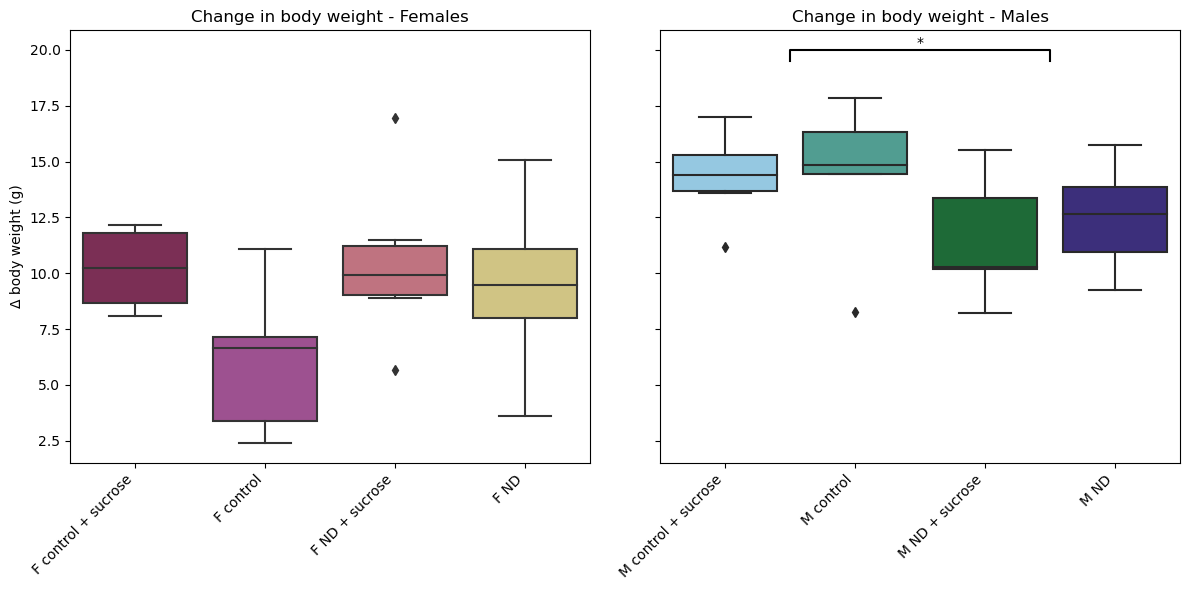

In [76]:
# Create the figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values, 8)

# Create boxplots
sns.boxplot(ax=ax[0], x='groupn', y='delta_bw', palette=palette[:4], data=df_pivot[df_pivot['sex'] == 'female'])
sns.boxplot(ax=ax[1], x='groupn', y='delta_bw', palette=palette[4:], data=df_pivot[df_pivot['sex'] == 'male'])

# Add titles and labels
ax[0].set_title('Change in body weight - Females')
ax[0].set_ylabel('Δ body weight (g)')
ax[0].set_xlabel('')
ax[1].set_title('Change in body weight - Males')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

# Set custom x-axis labels
ax[0].set_xticklabels(['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND'], rotation=45, ha='right')
ax[1].set_xticklabels(['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND'], rotation=45, ha='right')

# Adding significance annotation for the male plot (ax[1])
x1_index = 1  # Index for 'M control'
x2_index = 2  # Index for 'M ND'
y = 20  # Y-position for the significance line
text = '*'  # Text to indicate significance

# Plot the line indicating significance
ax[1].plot([x1_index-0.5, x1_index-0.5, x2_index+0.5, x2_index+0.5], [y-0.5, y, y, y-0.5], color='k', lw=1.5)
# Plot the asterisk
ax[1].text((x1_index + x2_index) * .5, y, text, ha='center', va='bottom', color='k')

# Creating legend handles for females and males
f_labels = ['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND']
m_labels = ['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND']
f_handles = [Patch(color=palette[i], label=label) for i, label in enumerate(f_labels)]
m_handles = [Patch(color=palette[i+4], label=label) for i, label in enumerate(m_labels)]

# Adjust layout
plt.tight_layout()
plt.show()


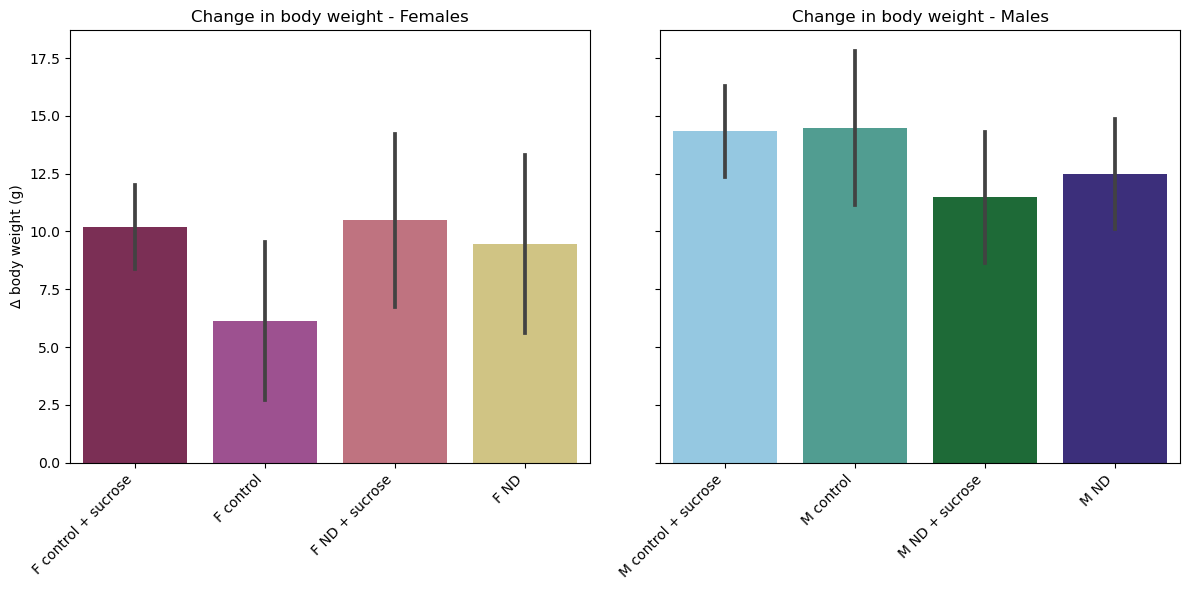

In [77]:
#same figure but then a barplot in case that is preferred. 
# Create the figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values, 8)

# Create bar plots
sns.barplot(ax=ax[0], x='groupn', y='delta_bw', palette=palette[:4], data=df_pivot[df_pivot['sex'] == 'female'], errorbar='sd')
sns.barplot(ax=ax[1], x='groupn', y='delta_bw', palette=palette[4:], data=df_pivot[df_pivot['sex'] == 'male'], errorbar='sd')

# Add titles and labels
ax[0].set_title('Change in body weight - Females')
ax[0].set_ylabel('Δ body weight (g)')
ax[0].set_xlabel('')
ax[1].set_title('Change in body weight - Males')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

# Set custom x-axis labels
ax[0].set_xticklabels(['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND'], rotation=45, ha='right')
ax[1].set_xticklabels(['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND'], rotation=45, ha='right')

# Creating legend handles for females and males
f_labels = ['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND']
m_labels = ['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND']
f_handles = [Patch(color=palette[i], label=label) for i, label in enumerate(f_labels)]
m_handles = [Patch(color=palette[i+4], label=label) for i, label in enumerate(m_labels)]

# Adjust layout
plt.tight_layout()
plt.show()


ANOVA

In [78]:
df_pivot.to_csv("..//results//bodyweightchange.csv")

Shapiro-Wilk test p-value: 0.3374328911304474
A normal distribution of the data can be assumed.


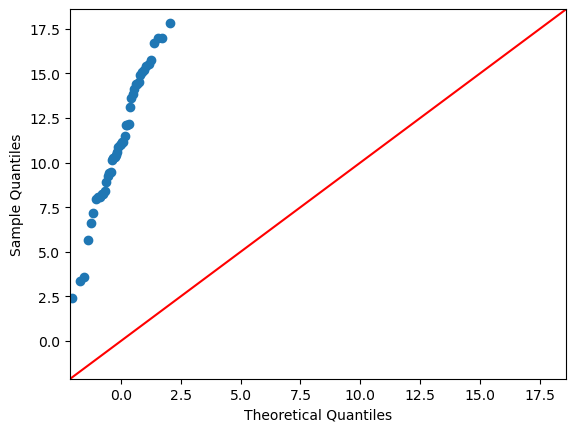

In [79]:
# perform tests on the data
# starting of by confirming the assumptions of an ANOVA

# normality
import statsmodels.api as sm
delta_bw = df_pivot['delta_bw']
fig = sm.qqplot(delta_bw, line='45') #sure it works but what does this say? 
# and am I even checking it correctly?

from scipy import stats
shapiro_test = stats.shapiro(delta_bw)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue) #okay the test says that it's normal

if shapiro_test.pvalue > 0.05:
    print("A normal distribution of the data can be assumed.")

In [80]:
#figuring out the equality of variances, using Levene's test
from statsmodels.formula.api import ols

# Fit the two-way ANOVA model
dependent_variable = 'delta_bw'
factor1 = 'diet'
factor2 = 'sucrose'
sex = 'sex'
formula = f'{dependent_variable} ~ C({factor1}) + C({factor2}) + C({sex}) + C({factor1}):C({factor2}) + C({factor1}):C({sex}) + C({factor2}):C({sex}) + C({factor1}):C({factor2}):C({sex})'
model = ols(formula, data=df_pivot).fit()

# Extract levels of each factor from the original DataFrame
factor1_levels = df_pivot[factor1].values
factor2_levels = df_pivot[factor2].values

# Calculate residuals from the fitted model
residuals = model.resid

# Calculate residuals for each combination of factor levels
grouped_residuals = []
for factor1_level in np.unique(factor1_levels):
    for factor2_level in np.unique(factor2_levels):
        mask = (factor1_levels == factor1_level) & (factor2_levels == factor2_level)
        grouped_residuals.append(residuals[mask])

# Perform Bartlett test for homogeneity of variances
bartlett_test = stats.bartlett(*grouped_residuals)
print("Bartlett test statistic:", bartlett_test.statistic)
print("Bartlett test p-value:", bartlett_test.pvalue)

if bartlett_test.statistic > 0.05:
    print("Equality of variances can be assumed.")

Bartlett test statistic: 3.9722525531267316
Bartlett test p-value: 0.2644759832439076
Equality of variances can be assumed.


In [81]:
#split the dataframe for sex
df_male = df_pivot[df_pivot['sex'] == 'male']
df_female = df_pivot[df_pivot['sex'] == 'female']


In [82]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA for males
model = ols('delta_bw ~ C(sucrose) + C(diet) + C(sucrose):C(diet)', data=df_male).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq    df         F    PR(>F)
C(sucrose)            2.061157   1.0  0.288629  0.597027
C(diet)              35.283750   1.0  4.940875  0.037921
C(sucrose):C(diet)    1.112269   1.0  0.155754  0.697273
Residual            142.823889  20.0       NaN       NaN

In [83]:
#perform two-way ANOVA for females
model = ols('delta_bw ~ C(sucrose) + C(diet) + C(sucrose):C(diet)', data=df_female).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq    df         F    PR(>F)
C(sucrose)           35.086875   1.0  3.199454  0.089620
C(diet)              17.154788   1.0  1.564287  0.226222
C(sucrose):C(diet)   13.298970   1.0  1.212688  0.284556
Residual            208.363852  19.0       NaN       NaN

In [84]:
#3 way anova
model_full = ols('delta_bw ~ C(sucrose) + C(diet) + C(sex) + C(sucrose):C(diet) + C(sucrose):C(sex) + C(diet):C(sex) + C(sucrose):C(diet):C(sex)', data=df_pivot).fit()
print(sm.stats.anova_lm(model_full, typ=2))

                               sum_sq    df          F    PR(>F)
C(sucrose)                   9.688205   1.0   1.075892  0.306007
C(diet)                      1.834179   1.0   0.203689  0.654259
C(sex)                     190.960044   1.0  21.206440  0.000043
C(sucrose):C(diet)          10.901897   1.0   1.210674  0.277944
C(sucrose):C(sex)           28.274119   1.0   3.139889  0.084212
C(diet):C(sex)              51.700008   1.0   5.741374  0.021464
C(sucrose):C(diet):C(sex)    3.509341   1.0   0.389718  0.536083
Residual                   351.187741  39.0        NaN       NaN


# Ratio
can we do the same for calorie intake?

In [85]:
# Pivot the DataFrame to get weights for specific dates in separate columns, store it in a new one from the previously cleaned up one
df_pivot_calorie = df_food_water.pivot(index='animal_id', columns='date', values='ratio').reset_index() 
df_pivot_calorie = df_pivot_calorie.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_calorie = df_pivot_calorie.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_calorie = df_pivot_calorie.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [86]:
# get average of the values of ratio for every 3 weeks

ratio_period1 = [pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
ratio_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
ratio_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
ratio_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot_calorie['week 1-3'] = df_pivot_calorie[ratio_period1].mean(axis=1)
df_pivot_calorie['week 4-6'] = df_pivot_calorie[ratio_period2].mean(axis=1)
df_pivot_calorie['week 7-9'] = df_pivot_calorie[ratio_period3].mean(axis=1)
df_pivot_calorie['week 10-12'] = df_pivot_calorie[ratio_period4].mean(axis=1)

#tried formatting the data because unequality of variances, but all attempts to equal it failed
df_pivot_calorie['loge_week 1-3'] = np.log(df_pivot_calorie[ratio_period1].mean(axis=1))
df_pivot_calorie['loge_week 4-6'] = np.log(df_pivot_calorie[ratio_period2].mean(axis=1))
df_pivot_calorie['loge_week 7-9'] = np.log(df_pivot_calorie[ratio_period3].mean(axis=1))
df_pivot_calorie['loge_week 10-12'] = np.log(df_pivot_calorie[ratio_period4].mean(axis=1))


In [87]:
df_pivot_calorie.to_csv("..//results//calorie_intake.csv")

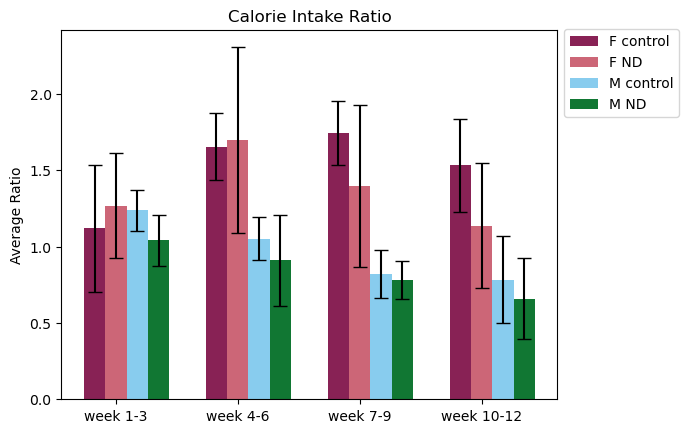

In [88]:
#Setting up the plot
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_calorie['sex'].unique()
conditions = ['control', 'experimental']
colors = ['#882255', '#CC6677', '#88CCEE', '#117733']

#Plotting
fig, ax = plt.subplots()

#Setting the bar width
bar_width = 0.35
num_conditions = len(conditions)

#Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

#indicate a colour map because otherwise later on I won't have 4 different colours
color_map = {
    ('female', 'control'): colors[0],
    ('female', 'experimental'): colors[1],
    ('male', 'control'): colors[2],
    ('male', 'experimental'): colors[3]
}

#Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].mean()
        errors = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].std()
        bar_position = index + (i * num_conditions + j) * bar_width / num_conditions
        ax.bar(bar_position, values, bar_width / num_conditions, label=f'{sex} - {condition}', yerr=errors, capsize=5,color=color_map[sex,condition])
        
#Adding labels and title
ax.set_xlabel('')
ax.set_ylabel('Average Ratio')
ax.set_title('Calorie Intake Ratio')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)

#Legend
custom_labels = ['F control', 'F ND','M control', 'M ND']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=custom_labels, bbox_to_anchor=(1, 1.02), loc='upper left')


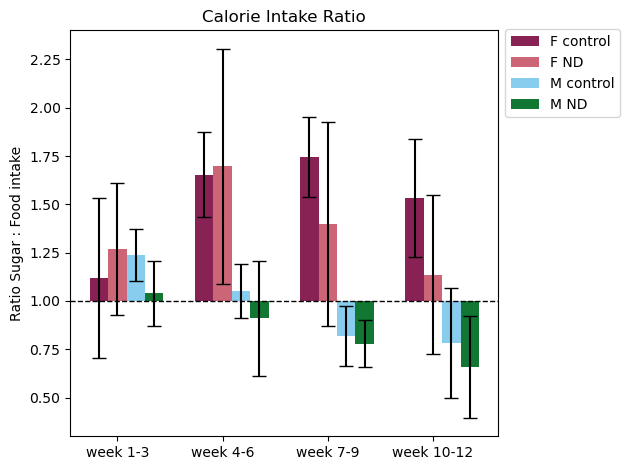

In [89]:
#but how fun would it be to have the ratio of 1 on the x axis? 

# Setting up the plot
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_calorie['sex'].unique()
conditions = ['control', 'experimental']
colors = ['#882255', '#CC6677', '#88CCEE', '#117733']

# Plotting
fig, ax = plt.subplots()

# Setting the bar width
bar_width = 0.35
num_conditions = len(conditions)

# Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

# Indicate a colour map because otherwise later on I won't have 4 different colours
color_map = {
    ('female', 'control'): colors[0],
    ('female', 'experimental'): colors[1],
    ('male', 'control'): colors[2],
    ('male', 'experimental'): colors[3]
}

# Baseline value
baseline = 1

# Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].mean()
        errors = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].std()
        
        # Calculate the bar height relative to the baseline
        heights = values - baseline
        errors = errors  # Assuming the errors are in the same scale as values

        bar_position = index + (i * num_conditions + j) * bar_width / num_conditions
        ax.bar(bar_position, heights, bar_width / num_conditions, bottom=baseline, label=f'{sex} - {condition}', yerr=errors, capsize=5, color=color_map[(sex, condition)])

# Adding labels and title
ax.set_xlabel('')
ax.set_ylabel('Ratio Sugar : Food intake')
ax.set_title('Calorie Intake Ratio')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)

# Draw a horizontal line at y=1 to represent the baseline
ax.axhline(y=baseline, color='black', linewidth=1, linestyle='--')

# Adjust y-axis limits to ensure the baseline line is visible
ax.set_ylim(min(0.3, 1.8))

# Legend
custom_labels = ['F control', 'F ND','M control', 'M ND']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=custom_labels, bbox_to_anchor=(1, 1.02), loc='upper left')

plt.tight_layout()


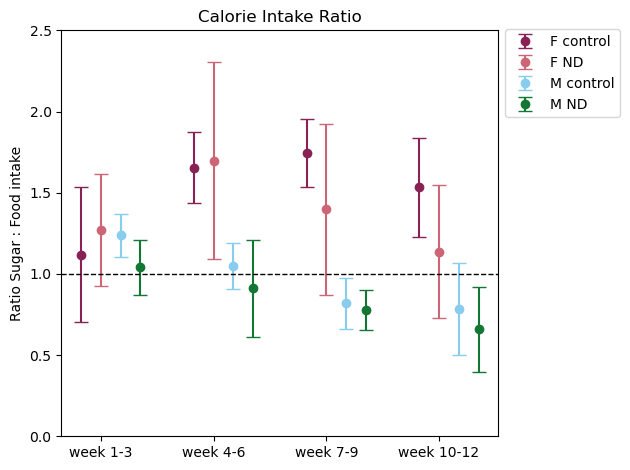

In [90]:
#Different plot option, the errorbar plot

# Setting up the plot
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_calorie['sex'].unique()
conditions = ['control', 'experimental']
colors = ['#882255', '#CC6677', '#88CCEE', '#117733']

# Plotting
fig, ax = plt.subplots()

# Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

# Indicate a colour map because otherwise later on I won't have 4 different colours
color_map = {
    ('female', 'control'): colors[0],
    ('female', 'experimental'): colors[1],
    ('male', 'control'): colors[2],
    ('male', 'experimental'): colors[3]
}

# Baseline value
baseline = 1

# Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].mean()
        errors = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].std()
        
        # Calculate the bar height relative to the baseline
        heights = values - baseline
        errors = errors 

        bar_position = index + (i * len(conditions) + j) * bar_width / len(conditions)
        ax.errorbar(bar_position, heights + baseline, yerr=errors, fmt='o', label=f'{sex} - {condition}', color=color_map[(sex, condition)], capsize=5)

# Adding labels and title
ax.set_xlabel('')
ax.set_ylabel('Ratio Sugar : Food intake')
ax.set_title('Calorie Intake Ratio')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)

# Draw a horizontal line at y=1 to represent the baseline
ax.axhline(y=baseline, color='black', linewidth=1, linestyle='--')

# Limits Y axis
ax.set_ylim(0, 2.5)

# Customize legend
custom_labels = ['F control', 'F ND', 'M control', 'M ND']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=custom_labels, bbox_to_anchor=(1, 1.02), loc='upper left')

plt.tight_layout()

In [99]:
#look at total calories as well 
df_pivot_tcalorie = df_food_water.pivot(index='animal_id', columns='date', values='total_calories').reset_index() 
df_pivot_tcalorie = df_pivot_tcalorie.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_tcalorie = df_pivot_tcalorie.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_tcalorie = df_pivot_tcalorie.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [100]:
# get average of the values of ratio for every 3 weeks

tcalorie_period1 = [pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
tcalorie_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
tcalorie_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
tcalorie_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot_tcalorie['week 1-3'] = df_pivot_tcalorie[tcalorie_period1].mean(axis=1)
df_pivot_tcalorie['week 4-6'] = df_pivot_tcalorie[tcalorie_period2].mean(axis=1)
df_pivot_tcalorie['week 7-9'] = df_pivot_tcalorie[tcalorie_period3].mean(axis=1)
df_pivot_tcalorie['week 10-12'] = df_pivot_tcalorie[tcalorie_period4].mean(axis=1)

#tried formatting the data because unequality of variances, but all attempts to equal it failed
df_pivot_tcalorie['loge_week 1-3'] = np.log(df_pivot_tcalorie[tcalorie_period1].mean(axis=1))
df_pivot_tcalorie['loge_week 4-6'] = np.log(df_pivot_tcalorie[tcalorie_period2].mean(axis=1))
df_pivot_tcalorie['loge_week 7-9'] = np.log(df_pivot_tcalorie[tcalorie_period3].mean(axis=1))
df_pivot_tcalorie['loge_week 10-12'] = np.log(df_pivot_tcalorie[tcalorie_period4].mean(axis=1))


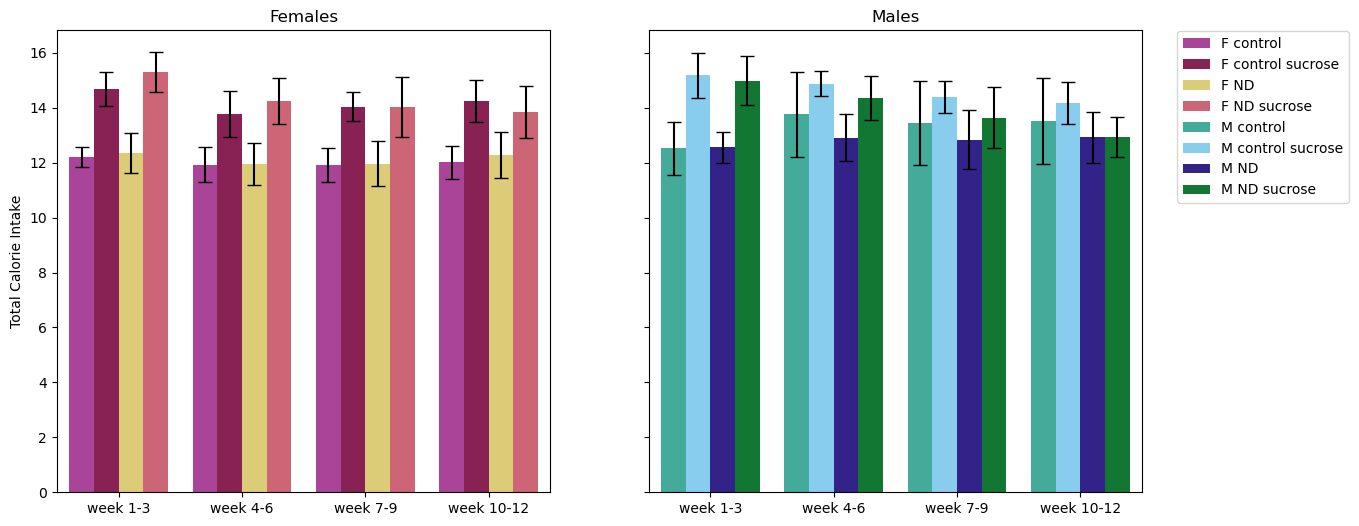

In [101]:
#The barplot
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_tcalorie['sex'].unique()
conditions = ['control', 'experimental']
sucrose_levels = df_pivot_tcalorie['sucrose'].unique()
colors = ['#AA4499', '#882255', '#DDCC77', '#CC6677', '#44AA99', '#88CCEE', '#332288', '#117733']

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Setting the bar width
bar_width = 0.2
num_conditions = len(conditions)
num_sucrose_levels = len(sucrose_levels)
total_groups = num_conditions * num_sucrose_levels

# Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

# Legend
labels = ['F control', 'F control sucrose','F ND', 'F ND sucrose','M control', 'M control sucrose', 'M ND', 'M ND sucrose']

# Plotting for each sex, condition, and sucrose level
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        for k, sucrose in enumerate(sucrose_levels):
            mask = (df_pivot_tcalorie['sex'] == sex) & (df_pivot_tcalorie['diet'] == condition) & (df_pivot_tcalorie['sucrose'] == sucrose)
            values = df_pivot_tcalorie[mask][periods].mean()
            errors = df_pivot_tcalorie[mask][periods].std()
            bar_position = index + (j * num_sucrose_levels + k) * bar_width
            color_index = (i * total_groups + j * num_sucrose_levels + k) % len(colors)
            ax = ax1 if sex == 'female' else ax2
            bar = ax.bar(bar_position, values, bar_width, label=f'{sex.capitalize()} - {condition} - {sucrose}', yerr=errors, capsize=5, color=colors[color_index])
            
            # Only add unique labels to handles and labels
            if f'{sex.capitalize()} - {condition} - {sucrose}' not in labels:
                handles.append(bar)
                labels.append(f'{sex.capitalize()} - {condition} - {sucrose}')

# Axes
ax1.set_title('Females')
ax1.set_xlabel('')
ax1.set_ylabel('Total Calorie Intake')
ax1.set_xticks(index + bar_width * total_groups / 2 - bar_width / 2)
ax1.set_xticklabels(periods)
ax1.set_xlim(index[0] - bar_width, index[-1] + bar_width * total_groups)

ax2.set_title('Males')
ax2.set_xlabel('')
ax2.set_xticks(index + bar_width * total_groups / 2 - bar_width / 2)
ax2.set_xticklabels(periods)
ax2.set_xlim(index[0] - bar_width, index[-1] + bar_width * total_groups)

# Custom Legend
fig.legend(labels, bbox_to_anchor=(0.92, 0.89), loc='upper left')


In [103]:
df_pivot_tcalorie.to_csv("..//results//total_calorie.csv")

Also make and store separate dataframes for food intake and sucrose intake separately

# food intake

In [44]:
# food intake
df_pivot_food = df_food_water.pivot(index='animal_id', columns='date', values='food_intake').reset_index() 
df_pivot_food = df_pivot_food.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_food = df_pivot_food.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_food = df_pivot_food.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [45]:
# bin the food intake just as with calorie ratio
##at the end, check the dates here!!!!!!
food_period1 = [pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
food_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
food_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
food_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot_food['week 1-3'] = df_pivot_food[food_period1].mean(axis=1)
df_pivot_food['week 4-6'] = df_pivot_food[food_period2].mean(axis=1)
df_pivot_food['week 7-9'] = df_pivot_food[food_period3].mean(axis=1)
df_pivot_food['week 10-12'] = df_pivot_food[food_period4].mean(axis=1)

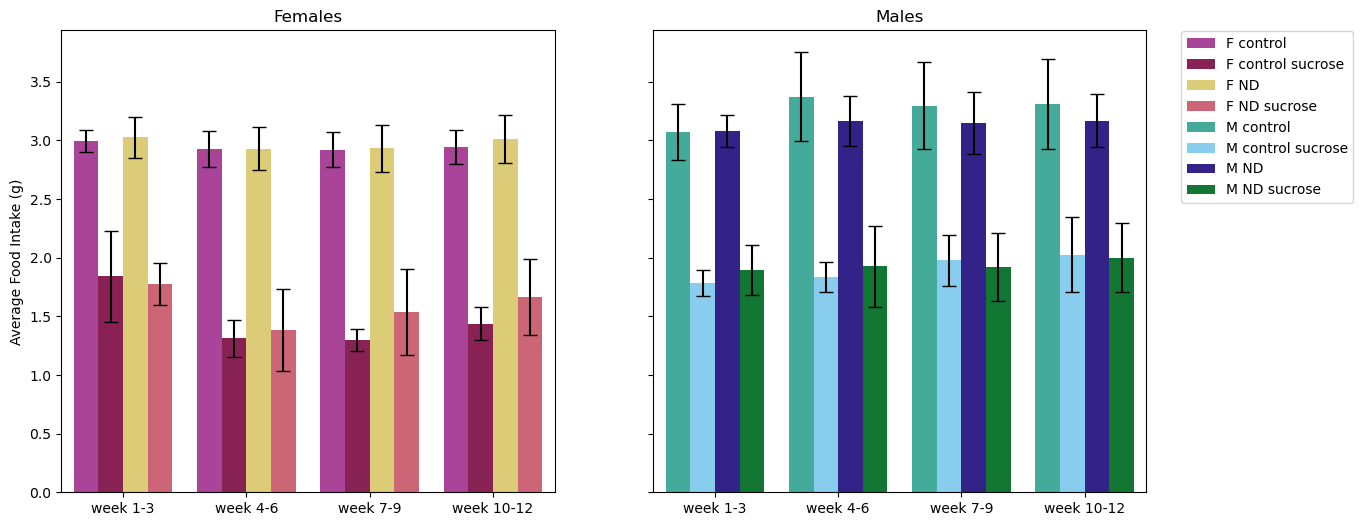

In [46]:
#The barplot
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_food['sex'].unique()
conditions = ['control', 'experimental']
sucrose_levels = df_pivot_food['sucrose'].unique()
colors = ['#AA4499', '#882255', '#DDCC77', '#CC6677', '#44AA99', '#88CCEE', '#332288', '#117733']

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Setting the bar width
bar_width = 0.2
num_conditions = len(conditions)
num_sucrose_levels = len(sucrose_levels)
total_groups = num_conditions * num_sucrose_levels

# Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

# Legend
labels = ['F control', 'F control sucrose','F ND', 'F ND sucrose','M control', 'M control sucrose', 'M ND', 'M ND sucrose']

# Plotting for each sex, condition, and sucrose level
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        for k, sucrose in enumerate(sucrose_levels):
            mask = (df_pivot_food['sex'] == sex) & (df_pivot_food['diet'] == condition) & (df_pivot_food['sucrose'] == sucrose)
            values = df_pivot_food[mask][periods].mean()
            errors = df_pivot_food[mask][periods].std()
            bar_position = index + (j * num_sucrose_levels + k) * bar_width
            color_index = (i * total_groups + j * num_sucrose_levels + k) % len(colors)
            ax = ax1 if sex == 'female' else ax2
            bar = ax.bar(bar_position, values, bar_width, label=f'{sex.capitalize()} - {condition} - {sucrose}', yerr=errors, capsize=5, color=colors[color_index])
            
            # Only add unique labels to handles and labels
            if f'{sex.capitalize()} - {condition} - {sucrose}' not in labels:
                handles.append(bar)
                labels.append(f'{sex.capitalize()} - {condition} - {sucrose}')

# Axes
ax1.set_title('Females')
ax1.set_xlabel('')
ax1.set_ylabel('Average Food Intake (g)')
ax1.set_xticks(index + bar_width * total_groups / 2 - bar_width / 2)
ax1.set_xticklabels(periods)
ax1.set_xlim(index[0] - bar_width, index[-1] + bar_width * total_groups)

ax2.set_title('Males')
ax2.set_xlabel('')
ax2.set_xticks(index + bar_width * total_groups / 2 - bar_width / 2)
ax2.set_xticklabels(periods)
ax2.set_xlim(index[0] - bar_width, index[-1] + bar_width * total_groups)

# Custom Legend
fig.legend(labels, bbox_to_anchor=(0.92, 0.89), loc='upper left')


In [47]:
df_pivot_food.to_csv("..//results//food_intake.csv")

In [48]:
# and now for sucrose intake
# food intake
df_pivot_sucrose = df_food_water.pivot(index='animal_id', columns='date', values='sucrose_intake').reset_index() 
df_pivot_sucrose = df_pivot_sucrose.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_sucrose = df_pivot_sucrose.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_sucrose = df_pivot_sucrose.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [49]:
#bin it, again in 3 week blocks
# bin the food intake just as with calorie ratio
##at the end, check the dates here!!!!!!
sucrose_period1 = [pd.Timestamp('2024-04-09 00:00:00'),
       pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
sucrose_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
sucrose_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
sucrose_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

#now link averages to these dates
df_pivot_sucrose['week 1-3'] = df_pivot_sucrose[sucrose_period1].mean(axis=1)
df_pivot_sucrose['week 4-6'] = df_pivot_sucrose[sucrose_period2].mean(axis=1)
df_pivot_sucrose['week 7-9'] = df_pivot_sucrose[sucrose_period3].mean(axis=1)
df_pivot_sucrose['week 10-12'] = df_pivot_sucrose[sucrose_period4].mean(axis=1)

#transformating because of unequality of variances
df_pivot_sucrose['1_week 1-3'] = 1/(df_pivot_sucrose[sucrose_period1].mean(axis=1))
df_pivot_sucrose['1_week 4-6'] = 1/(df_pivot_sucrose[sucrose_period2].mean(axis=1))
df_pivot_sucrose['1_week 7-9'] = 1/(df_pivot_sucrose[sucrose_period3].mean(axis=1))
df_pivot_sucrose['1_week 10-12'] = 1/(df_pivot_sucrose[sucrose_period4].mean(axis=1))

In [50]:
df_pivot_sucrose.to_csv("..//results//sucrose_intake.csv")

[Text(0.175, 0, 'week 1-3'),
 Text(1.175, 0, 'week 4-6'),
 Text(2.175, 0, 'week 7-9'),
 Text(3.175, 0, 'week 10-12')]

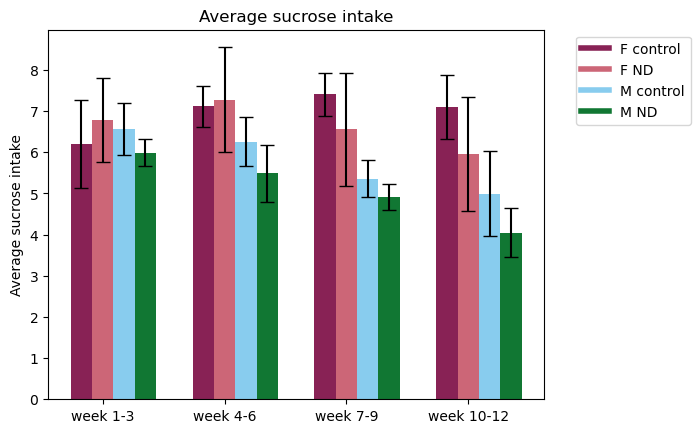

In [51]:
#Plot
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_sucrose['sex'].unique()
conditions = ['control', 'experimental']
fig, ax = plt.subplots()

#Setting the bar width
bar_width = 0.35
num_conditions = len(conditions)

#Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

#Indicating the preferred colours
colors = ['#882255', '#CC6677', '#88CCEE', '#117733']

#Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_sucrose[(df_pivot_sucrose['sex'] == sex) & (df_pivot_sucrose['diet'] == condition)][periods].mean()
        errors = df_pivot_sucrose[(df_pivot_sucrose['sex'] == sex) & (df_pivot_sucrose['diet'] == condition)][periods].std()
        bar_position = index + (i * num_conditions + j) * bar_width / num_conditions
        color_idx = (i * num_conditions + j) % len(colors)
        ax.bar(bar_position, values, bar_width / num_conditions, label=f'{sex} - {condition}', yerr=errors, capsize=5, color=colors[color_idx])

#The legend
custom_legend = [plt.Line2D([0], [0], color=colors[i % len(colors)], lw=4) for i in range(len(sexes) * len(conditions))]
custom_labels = ['F control', 'F ND', 'M control', 'M ND']
ax.legend(custom_legend, custom_labels, bbox_to_anchor=(1.05, 1), loc='upper left')        
        
#Adding labels and title
ax.set_xlabel('')
ax.set_ylabel('Average sucrose intake')
ax.set_title('Average sucrose intake')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)


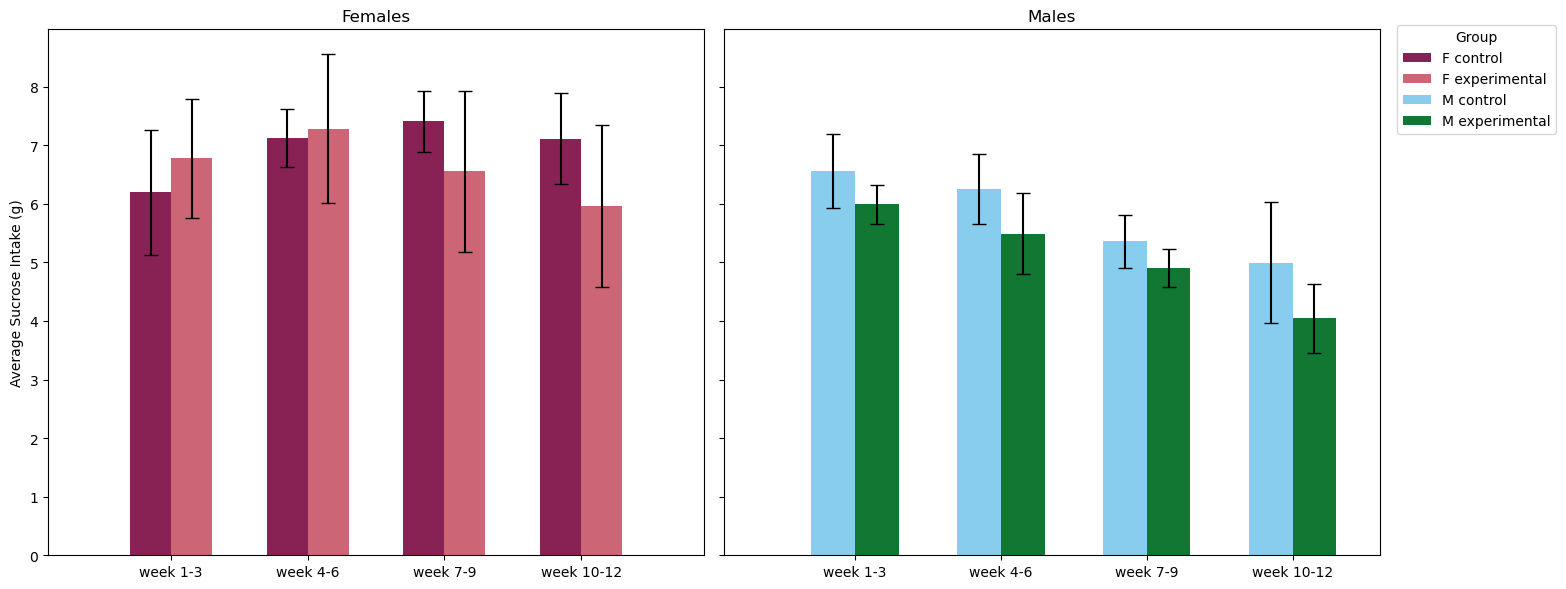

In [52]:
#now for males and females separately
periods = ['week 1-3', 'week 4-6', 'week 7-9', 'week 10-12']
sexes = df_pivot_sucrose['sex'].unique()
conditions = ['control', 'experimental']
colors = ['#882255', '#CC6677', '#88CCEE', '#117733']

# Create subplots: one for females and one for males
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Set bar width
bar_width = 0.6
num_conditions = len(conditions)
index = np.arange(len(periods))

# Initialize lists to collect handles and labels
handles_females, labels_females = [], []
handles_males, labels_males = [], []

# Plotting for females
ax1.set_title('Females')
ax1.set_xlabel('')
ax1.set_ylabel('Average Sucrose Intake (g)')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(periods)
ax1.set_xlim(index[0] - bar_width, index[-1] + bar_width * 2)

for j, condition in enumerate(conditions):
    values = df_pivot_sucrose[(df_pivot_sucrose['sex'] == 'female') & (df_pivot_sucrose['diet'] == condition)][periods].mean()
    errors = df_pivot_sucrose[(df_pivot_sucrose['sex'] == 'female') & (df_pivot_sucrose['diet'] == condition)][periods].std()
    bar_position = (index + j * (bar_width / num_conditions) - bar_width / 2) + 0.45
    handle = ax1.bar(bar_position, values, bar_width / num_conditions, label=f'F {condition}', yerr=errors, capsize=5, color=colors[j])
    handles_females.append(handle)
    labels_females.append(f'F {condition}')

# Plotting for males
ax2.set_title('Males')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticks(index + bar_width / 2)
ax2.set_xticklabels(periods)
ax2.set_xlim(index[0] - bar_width, index[-1] + bar_width * 1.5)

for j, condition in enumerate(conditions):
    values = df_pivot_sucrose[(df_pivot_sucrose['sex'] == 'male') & (df_pivot_sucrose['diet'] == condition)][periods].mean()
    errors = df_pivot_sucrose[(df_pivot_sucrose['sex'] == 'male') & (df_pivot_sucrose['diet'] == condition)][periods].std()
    bar_position = (index + j * (bar_width / num_conditions) - bar_width / 2) + 0.45
    handle = ax2.bar(bar_position, values, bar_width / num_conditions, label=f'M {condition}', yerr=errors, capsize=5, color=colors[j + 2])
    handles_males.append(handle)
    labels_males.append(f'M {condition}')

# Combine handles and labels from both subplots
handles = handles_females + handles_males
labels = labels_females + labels_males

#Legend
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 0.96), ncol=1, title='Group')
fig.tight_layout()

In [53]:
df_pivot_sucrose.to_csv("..//results//sucrose_intake.csv")

# body composition

In [54]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "echoMRI_results.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="results")

In [55]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 1
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 2
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 3
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 4
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 5
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 6
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 7
    else:
        return -1

def tweak_df(df2):
    return (df2
            .astype({
                "sex": "category",
                "diet": "category", 
                "fat_old": float,
                "lean_old": float,
                "fat_new": float,
                "lean_new": float,
                "bodyweight_old": float,
                "bodyweight_new": float,
                "fat_change": float,
                "lean_change": float
            })
            .assign(groupn=lambda df2_: df2_.apply(get_value, axis=1))
    )

df2 = tweak_df(pd.DataFrame(rows, columns=header))


In [56]:
df2

animal_id     sex          diet sucrose  fat_old  lean_old  fat_new  \
0      B3202  female       control      No   0.7475   17.8825   9.8525   
1      B3203  female  experimental      No   0.3575   18.4250  13.8700   
2      B3204  female  experimental      No   0.6300   17.2675   4.6450   
3      B3205  female       control      No   0.7350   17.4300   5.4350   
4      B3206  female       control      No   0.4575   16.8200   3.1125   
5      B3207  female  experimental      No   1.2375   17.0750   7.5850   
6      B3208  female  experimental      No   0.7175   18.5625  11.7750   
7      B3209  female       control     Yes   1.4725   16.4175   6.3025   
8      B3210  female       control     Yes   0.5175   18.2125  11.6550   
9      B3211  female       control      No   0.6450   17.4300   1.8625   
10     B3212  female       control      No   0.2625   17.8875   7.3600   
11     B3213  female       control     Yes   0.5050   18.2325   8.3925   
12     B3214  female       control     Yes   0.7800   17.4200   6.3375   
13     B3215  female  experimental      No   0.8600   16.5675  10.0075   
14     B3216  female  experimental      No   0.8275   19.0850   8.6600   
15     B3217  female       control     Yes   1.2600   16.7225   9.2275   
16     B3218  female       control     Yes   0.8900   19.0075  11.0925   
17     B3219  female  experimental     Yes   1.1075   18.3025  11.4150   
18     B3220  female  experimental     Yes   0.9550   17.3475   6.3625   
19     B3221  female  experimental     Yes   0.5375   17.6600   5.6275   
20     B3222  female  experimental     Yes   0.5250   16.8925   8.6275   
21     B3223  female  experimental     Yes   0.6100   17.9975  14.3975   
22     B3224  female  experimental     Yes   0.7775   17.6000  10.4400   
23     B3225    male       control     Yes   0.8225   23.2075  12.7325   
24     B3226    male       control     Yes   0.7175   22.6050  13.5975   
25     B3227    male       control     Yes   0.2350   22.8775  11.1925   
26     B3228    male       control     Yes   0.1225   24.0075  14.9650   
27     B3229    male       control      No   0.8650   19.3250  15.3050   
28     B3230    male       control      No   0.1450   21.6050   7.6275   
29     B3231    male  experimental      No   0.0850   22.1775  13.5175   
30     B3232    male  experimental      No   0.4100   21.4325   9.5125   
31     B3233    male  experimental     Yes   0.4175   22.2850  10.0475   
32     B3234    male  experimental     Yes   0.1825   21.8300  10.0850   
33     B3235    male       control     Yes   0.0400   20.8100  12.7725   
34     B3236    male       control     Yes   0.0975   22.5325  15.1950   
35     B3237    male  experimental     Yes   0.7175   22.5875  14.3050   
36     B3238    male  experimental     Yes   0.9525   23.1100  10.0025   
37     B3239    male       control      No   1.5375   22.9000  13.8625   
38     B3240    male       control      No   1.1000   22.9825  16.2825   
39     B3241    male       control      No   0.6325   23.8750  10.4350   
40     B3242    male       control      No   0.8750   22.4800  14.1825   
41     B3243    male  experimental      No   0.0525   22.1175  12.3475   
42     B3244    male  experimental      No   1.2450   21.9050  11.4175   
43     B3245    male  experimental      No   0.8625   22.0500   9.9900   
44     B3246    male  experimental      No   0.1275   24.5400  13.2100   
45     B3247    male  experimental     Yes   0.5925   23.2000   8.9175   
46     B3248    male  experimental     Yes   1.3500   23.6025  12.8100   

    lean_new  bodyweight_old  bodyweight_new  fat_change  lean_change  groupn  
0    20.8600            20.2            32.3      9.1050       2.9775       1  
1    22.8300            21.0            38.0     13.5125       4.4050       3  
2    18.9300            19.6            25.1      4.0150       1.6625       3  
3    21.6525            20.1            28.7      4.7000       4.2225       1  
4    19.9550            19.8            24.7      

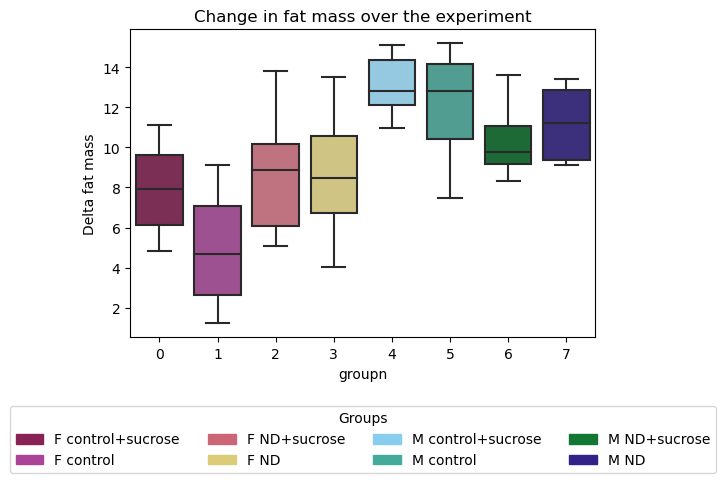

In [57]:
#visualise the new factor delta bodyweight in a boxplot
# Create a boxplot
plt.figure(figsize=(6, 4))
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values,8)
sns.boxplot(x='groupn', y='fat_change', palette = palette, data=df2)

# Add title and labels
plt.title('Change in fat mass over the experiment')
plt.ylabel('Delta fat mass')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)


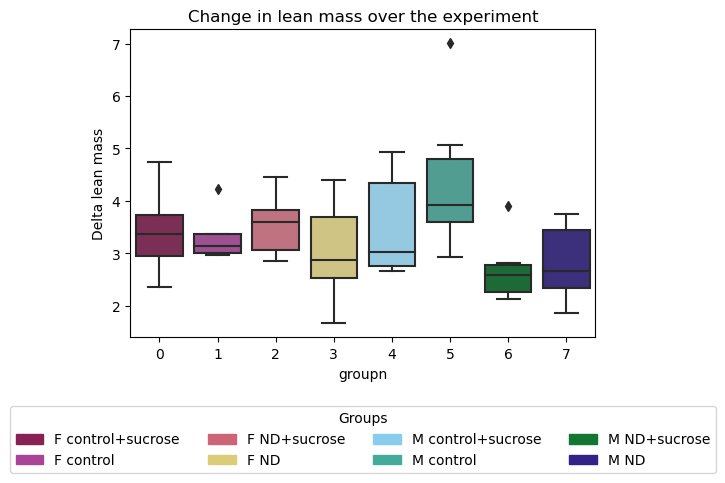

In [58]:
#visualise the new factor delta bodyweight in a boxplot
# Create a boxplot
plt.figure(figsize=(6, 4))
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values,8)
sns.boxplot(x='groupn', y='lean_change', palette = palette, data=df2)

# Add title and labels
plt.title('Change in lean mass over the experiment')
plt.ylabel('Delta lean mass')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)


In [59]:
#ook maar even een ratiootje ofzo doen, of iig % van gewicht is vet en dan t verschil van % berekenen
#new factor: ratio of calories from sucrose:food
df2['fat%_old'] = df2['fat_old'] / df2["bodyweight_old"] * 100
df2['fat%_new'] = df2['fat_new'] / df2['bodyweight_new'] *100
df2['fat%_change'] = df2['fat%_new'] - df2['fat%_old']
df2['lean%_old'] = df2['lean_old'] / df2["bodyweight_old"] * 100
df2['lean%_new'] = df2['lean_new'] / df2['bodyweight_new'] *100
df2['lean%_change'] = df2['lean%_new'] - df2['lean%_old']

In [60]:
df2.head()

animal_id     sex          diet sucrose  fat_old  lean_old  fat_new  \
0     B3202  female       control      No   0.7475   17.8825   9.8525   
1     B3203  female  experimental      No   0.3575   18.4250  13.8700   
2     B3204  female  experimental      No   0.6300   17.2675   4.6450   
3     B3205  female       control      No   0.7350   17.4300   5.4350   
4     B3206  female       control      No   0.4575   16.8200   3.1125   

   lean_new  bodyweight_old  bodyweight_new  fat_change  lean_change  groupn  \
0   20.8600            20.2            32.3      9.1050       2.9775       1   
1   22.8300            21.0            38.0     13.5125       4.4050       3   
2   18.9300            19.6            25.1      4.0150       1.6625       3   
3   21.6525            20.1            28.7      4.7000       4.2225       1   
4   19.9550            19.8            24.7      2.6550       3.1350       1   

   fat%_old   fat%_new  fat%_change  lean%_old  lean%_new  lean%_change  
0  3.700495  30.503096    26.802601  88.527228  64.582043    -23.945184  
1  1.702381  36.500000    34.797619  87.738095  60.078947    -27.659148  
2  3.214286  18.505976    15.291690  88.099490  75.418327    -12.681163  
3  3.656716  18.937282    15.280566  86.716418  75.444251    -11.272167  
4  2.310606  12.601215    10.290609  84.949495  80.789474     -4.160021

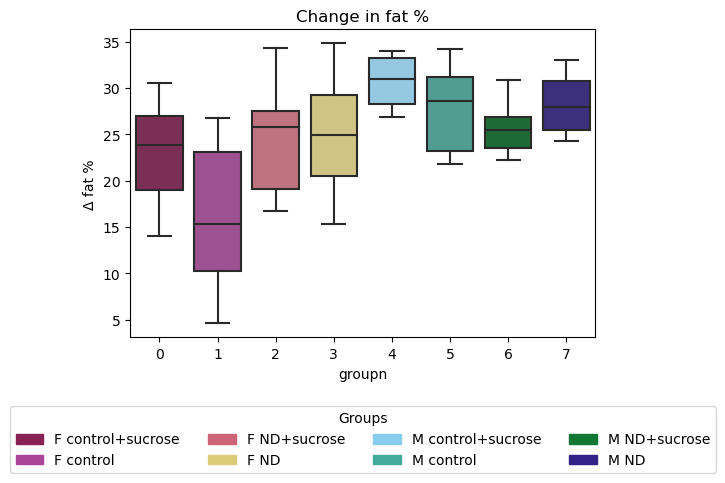

In [61]:
#visualise the new factor delta bodyweight in a boxplot
# Create a boxplot
plt.figure(figsize=(6, 4))
custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values,8)
sns.boxplot(x='groupn', y='fat%_change', palette = palette, data=df2)

# Add title and labels
plt.title('Change in fat %')
plt.ylabel('Δ fat %')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)


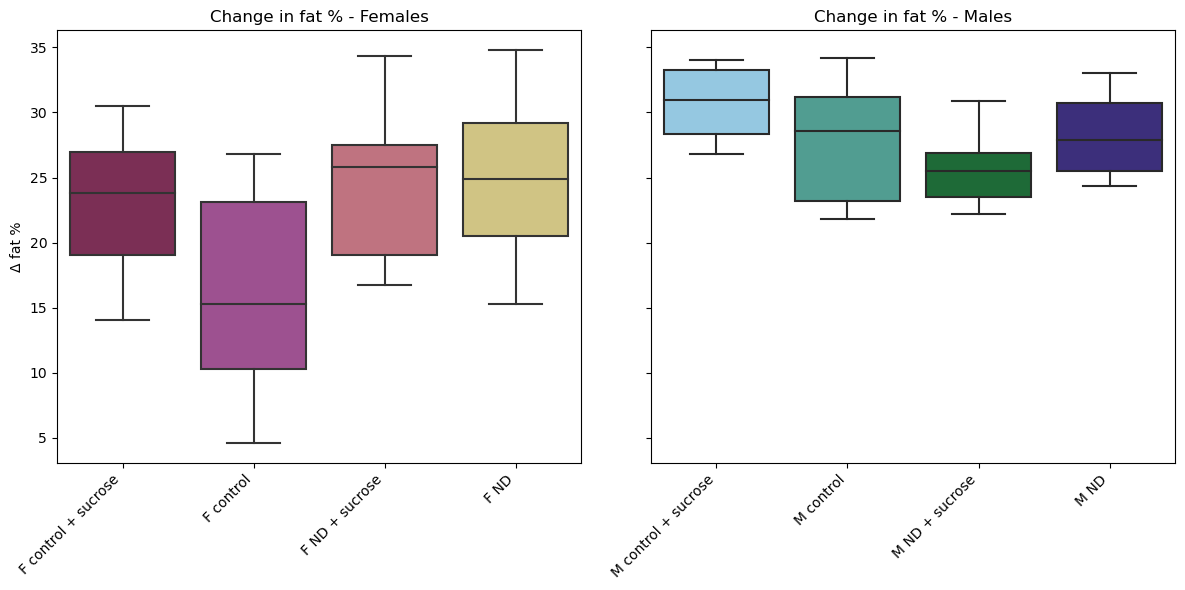

In [62]:
#Now a boxplot with males and females separately
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values, 8)

# Create boxplots
sns.boxplot(ax=ax[0], x='groupn', y='fat%_change', palette=palette[:4], data=df2[df2['sex'] == 'female'])
sns.boxplot(ax=ax[1], x='groupn', y='fat%_change', palette=palette[4:], data=df2[df2['sex'] == 'male'])

# Add titles and labels
ax[0].set_title('Change in fat % - Females')
ax[0].set_ylabel('Δ fat %')
ax[0].set_xlabel('')
ax[1].set_title('Change in fat % - Males')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

# Set custom x-axis labels
ax[0].set_xticklabels(['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND'], rotation=45, ha='right')
ax[1].set_xticklabels(['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND'], rotation=45, ha='right')

f_handles = [Patch(color=palette[i], label=label) for i, label in enumerate(f_labels)]
m_handles = [Patch(color=palette[i+4], label=label) for i, label in enumerate(m_labels)]

# Adjust layout
plt.tight_layout()


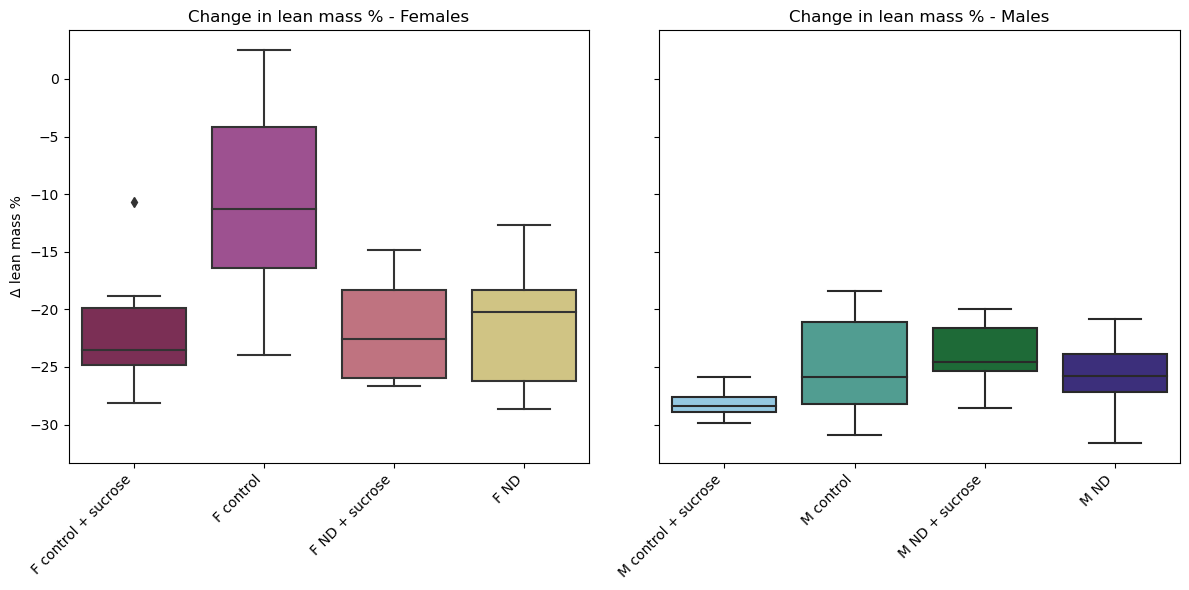

In [63]:
#Now the same for lean mass change
# Create a figure with two subplots
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

custom_hex_values = ['#882255','#AA4499','#CC6677','#DDCC77','#88CCEE','#44AA99','#117733','#332288']
palette = sns.color_palette(custom_hex_values, 8)

# Create boxplots
sns.boxplot(ax=ax[0], x='groupn', y='lean%_change', palette=palette[:4], data=df2[df2['sex'] == 'female'])
sns.boxplot(ax=ax[1], x='groupn', y='lean%_change', palette=palette[4:], data=df2[df2['sex'] == 'male'])

# Add titles and labels
ax[0].set_title('Change in lean mass % - Females')
ax[0].set_ylabel('Δ lean mass %')
ax[0].set_xlabel('')
ax[1].set_title('Change in lean mass % - Males')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

# Set custom x-axis labels
ax[0].set_xticklabels(['F control + sucrose', 'F control', 'F ND + sucrose', 'F ND'], rotation=45, ha='right')
ax[1].set_xticklabels(['M control + sucrose', 'M control', 'M ND + sucrose', 'M ND'], rotation=45, ha='right')

f_handles = [Patch(color=palette[i], label=label) for i, label in enumerate(f_labels)]
m_handles = [Patch(color=palette[i+4], label=label) for i, label in enumerate(m_labels)]

# Adjust layout
plt.tight_layout()


In [64]:
df2.to_csv("..//results//body_composition.csv")